In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.set_printoptions(precision=3, linewidth=500, threshold=500, suppress=True, edgeitems=5)

%load_ext autoreload
%autoreload 2
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from ndgsp.graph.graphs import Graph, ProductGraph
from ndgsp.graph.filters import MultivariateFilterFunction

from PIL import Image
import matplotlib.patches as mpatches
import matplotlib
import scipy as sp

2023-02-13 11:29:56.617526: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Using Jax backend with device TFRT_CPU_0


PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `T-V.pdf'.


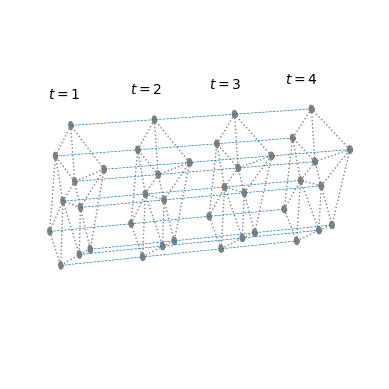

In [14]:
import subprocess 

def plot_TV_graph():
    """
    Plot a diagram depicting a time-vertex product graph
    """

    ax = plt.figure().add_subplot(projection='3d')

    np.random.seed(1)

    x = 2 * np.random.uniform(0, 10, size=10)
    z = 2 * np.random.uniform(0, 10, size=10)

    def add_point(x, y, z, r=1):

        theta = np.linspace(0, 2 * np.pi, 20)
        x_ = r * np.cos(theta) + x
        z_ = r * np.sin(theta) + z
        y_ = np.zeros_like(x_) + y

        ax.plot(x_, y_, z_, c='gray', lw=2)

    def add_edge(i, j, y):
        ax.plot([x[i], x[j]], [y, y], [z[i], z[j]], color='gray', lw=1, ls=':')


    edges  = [(0, 9),(0, 8),(0, 7),(0, 6),(0, 1),(1, 9),(1, 7),(1, 3),(3, 7),(3, 5), 
              (6, 7),(5, 6),(6, 8),(2, 5),(2, 6),(2, 4),(4, 6),(4, 8),(8, 9), (7, 5)]

    z0 = 0
    z1 = 10

    for y in np.linspace(z0, z1, 4):

        for i, j in edges:

            add_edge(i, j, y)



    for y in np.linspace(z0, z1, 4):


        for xx, zz in zip(x, z):

            add_point(xx, y, zz, 0.35)

    for xx, zz in zip(x, z):

        ax.plot([xx, xx], [z0, z1], [zz, zz], color='tab:blue', ls='--', lw=0.5)


    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_box_aspect([1, 2, 1])

    ax.set_axis_off()

    ax.view_init(9.54, -27.85)

    for i, y in enumerate(np.linspace(z0, z1, 4)):


        ax.text(0, y, 20, f'$t={i+1}$')

    plt.savefig('T-V.pdf')

    subprocess.run(['pdfcrop', 'T-V.pdf', 'T-V.pdf'])

plot_TV_graph()

In [56]:
def verify_eig_of_path_graph():
    """
    This function demonstrates that the eigenvalues and eigenvectors
    of the path graph are as given in the thesis
    """


    T = 101
    G = Graph.chain(T)

    # compute eigen-decomposition using closed-form solution 
    lam = 2 - 2 * np.cos(T ** -1 * np.pi * np.arange(T))
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    # check the decomposition recreates the Laplacian
    assert np.allclose(G.L, U @ np.diag(lam) @ U.T)

    return True



verify_eig_of_path_graph()

True

In [75]:
def verify_DCT():
    """
    This function verifies that the GFT and the IGFT are given by the Discrete 
    Cosine Transform (DCT) and the Inverse DCT respectively. 
    """

    def Uy(y):
        return sp.fft.idct(y.T, type=2, norm='ortho').T

    def UTy(y):
        return sp.fft.dct(y.T, type=2, norm='ortho').T

    def yU(y):
        return sp.fft.dct(y, type=2, norm='ortho')

    def yUT(y):
        return sp.fft.idct(y, type=2, norm='ortho')

    T = 101

    # compute eigen-decomposition using closed-form solution 
    U = np.cos(T ** -1 * np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)))
    U /= np.linalg.norm(U, axis=0)

    for shape in [(T), (T, 5), (5, T)]:

        y = np.random.normal(size=shape)
        
        if shape != (5, T):
            assert np.allclose(U.T @ y, UTy(y))
            assert np.allclose(U @ y, Uy(y))

        if shape != (T, 5):
            assert np.allclose(y @ U.T, yUT(y))
            assert np.allclose(y @ U, yU(y))

    return True

verify_DCT()


True

In [59]:
YY = np.random.normal(size=(T, 5))

In [73]:
assert np.allclose(U @ y, Uy(y))

In [71]:
YY.T @ U.T

array([[-1.067,  0.876, -1.928,  0.189, -1.078, ..., -0.172,  0.332, -1.446,  0.755,  0.569],
       [-0.246,  0.662,  0.914, -0.279,  0.48 , ...,  0.497,  0.097,  0.211, -0.649, -0.289],
       [-0.6  , -0.612, -1.312, -0.366,  0.173, ..., -2.085,  0.03 , -1.012,  0.617,  1.053],
       [-0.039,  0.461,  0.473, -0.447,  0.151, ...,  1.284,  0.548, -0.642,  0.623,  1.496],
       [ 0.202, -1.18 , -1.418, -0.974,  1.333, ...,  1.15 ,  0.466, -0.84 , -0.892, -1.647]])

In [4]:
import time
from tqdm.notebook import tqdm


In [19]:
def plot_MM_vs_CDT():
    """
    Plot a graph demonstrating the difference in compute time across a range 
    of T values for matrix multiplication vs the DCT for GFT of the path graph. 
    """

    Ts = np.linspace(10, 1.5e4, 20).astype(int)
    ts_gft = []
    ts_dct = []

    for T in tqdm(Ts):

        U = np.cos( np.pi * np.outer(np.arange(T) + 0.5, np.arange(T)) / T)
        U /= np.linalg.norm(U, axis=0)

        y = np.random.normal(size=T)

        t0 = time.time()
        for i in range(5):
            U.T @ y
        ts_gft.append((time.time() - t0) / 5)

        t0 = time.time()
        for i in range(5):
            sp.fft.dct(y, type=2, norm='ortho')
        ts_dct.append((time.time() - t0) / 5)

    plt.figure()

    plt.plot(Ts, ts_gft, label='Matrix multiplication')
    plt.plot(Ts, ts_dct, label='FCT')

    plt.legend()

    plt.xlabel('$T$')
    plt.ylabel('Time [s]')

    plt.xticks(np.arange(0, 15001, 2500))

    plt.savefig('DCT.pdf', transparent=True)

    
plot_MM_vs_CDT()




  0%|          | 0/20 [00:00<?, ?it/s]